# Deep Residual Learning For Image Recognition

Some jargons I'm not familiar with when first reading. I will explain them in detail later on.

The whole passage will include two main parts:
1. **Classification tasks on CIFAR-10**
2. **Object Detection on PASCAL and MS COCO**

In [1]:
#notebook setup
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR


import numpy as np
from utils import progress_bar

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

And also some useful function:

In [2]:
def show_images(imgs):
    NUM = imgs.shape[0]
    
    sqrtn = int(np.ceil(np.sqrt(NUM)))
    sqrtimg = int(np.ceil(np.sqrt(NUM)))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(imgs):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)
    return

## Classification tasks on CIFAR-10

First we need to download the data if needed. And then preprocess as following:

1. 4 pixels padding and random cropping
2. flipping randomly
3. normalize

***

The intuition behind them are explained [here](https://stackoverflow.com/questions/32842308/random-cropping-and-flipping-in-convolutional-neural-networks/32844299):

>This is referred to as **data augmentation**. By applying transformations to the training data, you're adding synthetic data points. This exposes the model to additional variations without the cost of collecting and annotating more data. This can have the effect of reducing overfitting and improving the model's ability to generalize.

>The intuition behind **flipping** an image is that an object should be equally recognizable as its mirror image. Note that horizontal flipping is the type of flipping often used. Vertical flipping doesn't always make sense but this depends on the data.

>The idea behind **cropping** is that to reduce the contribution of the background in the CNNs decision. That's useful if you have labels for locating where your object is. This lets you use surrounding regions as negative examples and building a better detector. Random cropping can also act as a regularizer and base your classification on the presence of parts of the object *instead of focusing everything on a very distinct feature* that may not always be present.

And a very approaching idea on random cropping:

>I think random cropping also associate a broader range of spatial activation statistics with a certain class label and thus makes the algorithm more robust.

***

Some tips here:
1. just mentioned CIFAR in PyTorch will load all data into memory at the beginning, not to large.
2. T.ToTensor will convert img in the range [0,255] to that in [0,1]. Some codes Normalize them using (0.5,0.5,0.5) to rescale it to range(-1,1) after ToTensor operation.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


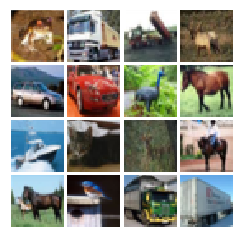

In [3]:
# size of the image dataset N * 32 * 32 * 3
NUM_TRAIN = 45000
NUM_VAL = 5000


train_CIFAR = dset.CIFAR10('../datasets/', train=True, download=True)
train_mean = np.mean(train_CIFAR.train_data, axis=(0,1,2))/255
train_std = np.std(train_CIFAR.train_data, axis=(0,1,2))/255

train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(train_mean, train_std)
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(train_mean, train_std)
])
train_CIFAR = dset.CIFAR10('../datasets/', train=True, download=True, transform = train_transform)
train_loader = DataLoader(train_CIFAR, batch_size = 128, num_workers=2, 
                          sampler= SubsetRandomSampler(list(range(NUM_TRAIN))))
val_loader = DataLoader(train_CIFAR, batch_size = 128, num_workers=2, 
                          sampler= SubsetRandomSampler(list(range(NUM_TRAIN,(NUM_TRAIN+NUM_VAL)))))

test_CIFAR = dset.CIFAR10('../datasets/', train=False, download=True, transform= test_transform)
test_loader = DataLoader(test_CIFAR, batch_size = 128, num_workers=2, shuffle=False)

NUM_SHOW = 16

img =train_CIFAR.train_data[:NUM_SHOW,:]
show_images(img)

Then we will import Resnet-18, 50 to train our dataset on the training data. These two models use different architecture, one with basic block and the other with one called bottleneck. I specifically choose these two different sorts of models with relatively less layers due to the limit of the computational resources.

Some points need to pay attention to:
1. I update the learning rate by a decreasing factor of 0.1 at epoch 100 and 150
2. 

In [6]:
RESUME = False

from resnet import Resnet18


net = Resnet18()
if RESUME:
    state = torch
    net = 1

learning_rate=0.1
weight_decay = 0.0001

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=weight_decay)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=8e-4, nesterov= True)
scheduler = MultiStepLR(optimizer, [100,150], gamma=0.1)

In [7]:
use_cuda = torch.cuda.is_available()
#msg = 
print('GPU %s available on this machine!' %('is' if use_cuda else 'is not' ))
if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

def train(epoch):
    global loss_hist, train_acc_hist, val_acc_hist, test_acc_hist
    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    test_acc_hist = []
    
    for i in range(epoch):
        print('This is epoch:{}'.format(i+1))
        total= 0
        correct=0
        scheduler.step()
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss.data[0], 100.*correct/total, correct, total))
            if j % 50==0:
                loss_hist.append(loss.data[0])
            
        train_acc_hist.append(100.*correct/total)
        if i %1 == 0:
            acc = test(val_loader)
            val_acc_hist.append(acc)
            print('Epoch {}, loss: {}, accuracy: {}'.format(i+1, loss_hist[-1], acc))
            acc = test(test_loader)
            test_acc_hist.append(acc)
            print('Epoch {}, loss: {}, accuracy: {}'.format(i+1, loss_hist[-1], acc))
                
def test(val_load):
    net.eval()
    total = 0
    positive = 0
    for val_x, val_y in val_load:
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #print(out.size())
        positive += (torch.max(out,1)[1]==y).sum().data[0]
        total += out.size()[0]
    acc =  (positive*100.0)/total
    return acc     

train(200)

GPU is available on this machine!
This is epoch:1
 [============================================>] 352/352   Step: 143ms | Tot: 1m17s | Loss: 1.298 | Acc: 38.960% (17532/45000)4))
Epoch 1, loss: 1.1875641345977783, accuracy: 44.88
Epoch 1, loss: 1.1875641345977783, accuracy: 45.34
This is epoch:2
 [============================================>] 352/352   Step: 145ms | Tot: 1m17s | Loss: 0.727 | Acc: 57.956% (26080/45000)4))
Epoch 2, loss: 0.9993833303451538, accuracy: 53.66
Epoch 2, loss: 0.9993833303451538, accuracy: 53.23
This is epoch:3
 [============================================>] 352/352   Step: 146ms | Tot: 1m16s | Loss: 0.876 | Acc: 68.071% (30632/45000)4))
Epoch 3, loss: 0.7159119248390198, accuracy: 58.98
Epoch 3, loss: 0.7159119248390198, accuracy: 59.03
This is epoch:4
 [============================================>] 352/352   Step: 146ms | Tot: 1m16s | Loss: 0.691 | Acc: 73.153% (32919/45000)4))
Epoch 4, loss: 0.6562046408653259, accuracy: 66.86
Epoch 4, loss: 0.65620464

Epoch 33, loss: 0.495261013507843, accuracy: 78.88
This is epoch:34
 [============================================>] 352/352   Step: 145ms | Tot: 1m16s | Loss: 0.407 | Acc: 84.362% (37963/45000)2))
Epoch 34, loss: 0.503936231136322, accuracy: 75.76
Epoch 34, loss: 0.503936231136322, accuracy: 76.77
This is epoch:35
 [============================================>] 352/352   Step: 147ms | Tot: 1m16s | Loss: 0.392 | Acc: 84.416% (37987/45000)2))
Epoch 35, loss: 0.39127981662750244, accuracy: 76.56
Epoch 35, loss: 0.39127981662750244, accuracy: 77.54
This is epoch:36
 [============================================>] 352/352   Step: 144ms | Tot: 1m16s | Loss: 0.352 | Acc: 84.402% (37981/45000)2))
Epoch 36, loss: 0.27022048830986023, accuracy: 73.74
Epoch 36, loss: 0.27022048830986023, accuracy: 75.18
This is epoch:37
 [============================================>] 352/352   Step: 145ms | Tot: 1m16s | Loss: 0.347 | Acc: 84.344% (37955/45000)2))
Epoch 37, loss: 0.4062145948410034, accuracy: 7

 [============================================>] 352/352   Step: 147ms | Tot: 1m16s | Loss: 0.402 | Acc: 85.213% (38346/45000)2))
Epoch 66, loss: 0.3105930685997009, accuracy: 80.24
Epoch 66, loss: 0.3105930685997009, accuracy: 81.04
This is epoch:67
 [============================================>] 352/352   Step: 147ms | Tot: 1m16s | Loss: 0.560 | Acc: 85.113% (38301/45000)2))
Epoch 67, loss: 0.4955814778804779, accuracy: 77.9
Epoch 67, loss: 0.4955814778804779, accuracy: 78.89
This is epoch:68
 [============================================>] 352/352   Step: 146ms | Tot: 1m16s | Loss: 0.644 | Acc: 85.353% (38409/45000)2))
Epoch 68, loss: 0.44800764322280884, accuracy: 73.52
Epoch 68, loss: 0.44800764322280884, accuracy: 73.24
This is epoch:69
 [============================================>] 352/352   Step: 145ms | Tot: 1m16s | Loss: 0.638 | Acc: 85.116% (38302/45000)2))
Epoch 69, loss: 0.34388139843940735, accuracy: 73.88
Epoch 69, loss: 0.34388139843940735, accuracy: 73.52
This is ep

Epoch 98, loss: 0.39011359214782715, accuracy: 80.73
This is epoch:99
 [============================================>] 352/352   Step: 145ms | Tot: 1m16s | Loss: 0.481 | Acc: 85.464% (38459/45000)2))
Epoch 99, loss: 0.4421716332435608, accuracy: 79.18
Epoch 99, loss: 0.4421716332435608, accuracy: 78.92
This is epoch:100
 [============================================>] 352/352   Step: 144ms | Tot: 1m16s | Loss: 0.610 | Acc: 85.271% (38372/45000)2))
Epoch 100, loss: 0.486907422542572, accuracy: 74.04
Epoch 100, loss: 0.486907422542572, accuracy: 71.84
This is epoch:101
 [============================================>] 352/352   Step: 146ms | Tot: 1m16s | Loss: 0.165 | Acc: 91.529% (41188/45000)2))
Epoch 101, loss: 0.20194803178310394, accuracy: 91.36
Epoch 101, loss: 0.20194803178310394, accuracy: 91.25
This is epoch:102
 [============================================>] 352/352   Step: 144ms | Tot: 1m16s | Loss: 0.088 | Acc: 93.836% (42226/45000)2))
Epoch 102, loss: 0.2564411759376526, acc

 [============================================>] 352/352   Step: 145ms | Tot: 1m16s | Loss: 0.142 | Acc: 97.002% (43651/45000)0))
Epoch 131, loss: 0.047489576041698456, accuracy: 89.22
Epoch 131, loss: 0.047489576041698456, accuracy: 90.0
This is epoch:132
 [============================================>] 352/352   Step: 144ms | Tot: 1m16s | Loss: 0.102 | Acc: 96.918% (43613/45000)0))
Epoch 132, loss: 0.09039213508367538, accuracy: 90.08
Epoch 132, loss: 0.09039213508367538, accuracy: 90.16
This is epoch:133
 [============================================>] 352/352   Step: 144ms | Tot: 1m16s | Loss: 0.115 | Acc: 96.847% (43581/45000)0))
Epoch 133, loss: 0.14985139667987823, accuracy: 90.18
Epoch 133, loss: 0.14985139667987823, accuracy: 91.21
This is epoch:134
 [============================================>] 352/352   Step: 145ms | Tot: 1m16s | Loss: 0.092 | Acc: 96.949% (43627/45000)0))
Epoch 134, loss: 0.10334012657403946, accuracy: 90.36
Epoch 134, loss: 0.10334012657403946, accuracy:

 [============================================>] 352/352   Step: 144ms | Tot: 1m16s | Loss: 0.032 | Acc: 99.884% (44948/45000)0))
Epoch 163, loss: 0.007225237786769867, accuracy: 93.96
Epoch 163, loss: 0.007225237786769867, accuracy: 94.27
This is epoch:164
 [============================================>] 352/352   Step: 141ms | Tot: 1m16s | Loss: 0.006 | Acc: 99.907% (44958/45000)0))
Epoch 164, loss: 0.004870187491178513, accuracy: 93.5
Epoch 164, loss: 0.004870187491178513, accuracy: 94.21
This is epoch:165
 [============================================>] 352/352   Step: 141ms | Tot: 1m16s | Loss: 0.006 | Acc: 99.913% (44961/45000)0))
Epoch 165, loss: 0.011271875351667404, accuracy: 93.9
Epoch 165, loss: 0.011271875351667404, accuracy: 94.22
This is epoch:166
 [============================================>] 352/352   Step: 144ms | Tot: 1m16s | Loss: 0.002 | Acc: 99.904% (44957/45000)0))
Epoch 166, loss: 0.003360789269208908, accuracy: 93.76
Epoch 166, loss: 0.003360789269208908, accu

Epoch 194, loss: 0.0037546679377555847, accuracy: 94.42
This is epoch:195
 [============================================>] 352/352   Step: 142ms | Tot: 1m16s | Loss: 0.004 | Acc: 99.976% (44989/45000)0)))
Epoch 195, loss: 0.0025104545056819916, accuracy: 93.7
Epoch 195, loss: 0.0025104545056819916, accuracy: 94.48
This is epoch:196
 [============================================>] 352/352   Step: 143ms | Tot: 1m16s | Loss: 0.003 | Acc: 99.971% (44987/45000)0))
Epoch 196, loss: 0.002840988337993622, accuracy: 94.04
Epoch 196, loss: 0.002840988337993622, accuracy: 94.33
This is epoch:197
 [============================================>] 352/352   Step: 145ms | Tot: 1m16s | Loss: 0.003 | Acc: 99.973% (44988/45000)0))
Epoch 197, loss: 0.0038035064935684204, accuracy: 93.72
Epoch 197, loss: 0.0038035064935684204, accuracy: 94.34
This is epoch:198
 [============================================>] 352/352   Step: 142ms | Tot: 1m16s | Loss: 0.003 | Acc: 99.987% (44994/45000)0))
Epoch 198, loss: 0

In [9]:
import pickle

train_data={}
train_data['loss_hist'] = loss_hist
train_data['train_acc_hist'] = train_acc_hist
train_data['val_acc_hist'] =  val_acc_hist
train_data['test_acc_hist'] =  test_acc_hist
with open('resnet18data.pkl','wb') as f:
    pickle.dump(train_data,f)
# use_cuda = torch.cuda.is_available()
# use_cuda
# #net.module
# print(train_mean, train_std)
# list(range(NUM_TRAIN,(NUM_TRAIN+NUM_VAL)))

GPU is available on this machine!
This is epoch:1
 [================================================================>]  Step: 1s86ms | Tot: 6m30s | Loss: 1.903 | Acc: 19.849% (8932/45000) 352/352  2 
Epoch 1, loss: 1.9031935930252075, accuracy: 0.1562
Epoch 1, loss: 1.9031935930252075, accuracy: 0.1019
This is epoch:2
 [================================================================>]  Step: 1s83ms | Tot: 6m28s | Loss: 1.974 | Acc: 22.273% (10023/45000) 352/352   
Epoch 2, loss: 1.974468469619751, accuracy: 0.1098
Epoch 2, loss: 1.974468469619751, accuracy: 0.1224
This is epoch:3
 [================================================================>]  Step: 1s65ms | Tot: 6m25s | Loss: 1.839 | Acc: 23.507% (10578/45000) 352/352  
Epoch 3, loss: 1.838523268699646, accuracy: 0.1248
Epoch 3, loss: 1.838523268699646, accuracy: 0.1001
This is epoch:4
 [================================================================>]  Step: 1s67ms | Tot: 6m24s | Loss: 1.874 | Acc: 23.542% (10594/45000) 352/352  
Epoch 4, loss: 1.8741010427474976, accuracy: 0.1158
Epoch 4, loss: 1.8741010427474976, accuracy: 0.113
This is epoch:5
 [================================================================>]  Step: 1s50ms | Tot: 6m23s | Loss: 1.874 | Acc: 23.982% (10792/45000) 352/352 2 
Epoch 5, loss: 1.874094843864441, accuracy: 0.1788
Epoch 5, loss: 1.874094843864441, accuracy: 0.1691
This is epoch:6
 [================================================================>]  Step: 1s52ms | Tot: 6m22s | Loss: 1.858 | Acc: 26.613% (11976/45000) 352/352 2 
Epoch 6, loss: 1.85829496383667, accuracy: 0.1688
Epoch 6, loss: 1.85829496383667, accuracy: 0.1111
This is epoch:7


GPU is available on this machine!
This is epoch:1
 [============================================>] 391/391   Step: 2s520ms | Tot: 3m2s | Loss: 1.405 | Acc: 35.196% (17598/50000))
Epoch 1, loss: 1.5890774726867676, accuracy: 40.6
This is epoch:2
 [============================================>] 391/391   Step: 327ms | Tot: 3m398ms | Loss: 1.009 | Acc: 52.516% (26258/50000)
Epoch 2, loss: 1.2520461082458496, accuracy: 54.61
This is epoch:3
 [============================================>] 391/391   Step: 329ms | Tot: 3m254ms | Loss: 0.741 | Acc: 62.134% (31067/50000)
Epoch 3, loss: 1.0879250764846802, accuracy: 55.75
This is epoch:4
 [============================================>] 391/391   Step: 319ms | Tot: 3m340ms | Loss: 0.660 | Acc: 68.828% (34414/50000))
Epoch 4, loss: 0.7853685617446899, accuracy: 64.93
This is epoch:5
 [============================================>] 391/391   Step: 335ms | Tot: 2m59s | Loss: 0.866 | Acc: 73.106% (36553/50000)4))
Epoch 5, loss: 0.787162184715271, accuracy: 73.92